# Few-Shot Bioacoustic Detection - Model Evaluation

This notebook evaluates the performance of the trained model by comparing predictions against ground truth annotations.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Predictions and Ground Truth

In [2]:
# Paths
predictions_dir = 'output_verify'  # Your predictions
ground_truth_dir = '/data/msc-proj/Validation_Set_DSAI_2025_2026'  # Ground truth

# Find all prediction files
pred_files = glob.glob(os.path.join(predictions_dir, '*.csv'))
print(f"Found {len(pred_files)} prediction files")

# Display first few
for f in pred_files[:3]:
    print(f"  - {os.path.basename(f)}")

Found 11 prediction files
  - ME1.csv
  - BUK4_20161031_232104a.csv
  - BUK1_20181011_001004.csv


## 2. Event-Based Metrics

We'll use **Intersection over Union (IoU)** to match predicted events with ground truth events.

In [3]:
def compute_iou(pred_start, pred_end, gt_start, gt_end):
    """Compute Intersection over Union for two time intervals."""
    intersection_start = max(pred_start, gt_start)
    intersection_end = min(pred_end, gt_end)
    intersection = max(0, intersection_end - intersection_start)
    
    union_start = min(pred_start, gt_start)
    union_end = max(pred_end, gt_end)
    union = union_end - union_start
    
    return intersection / union if union > 0 else 0

def match_events(predictions, ground_truth, iou_threshold=0.5):
    """
    Match predicted events to ground truth events using IoU.
    
    Returns:
        tp: True Positives (matched predictions)
        fp: False Positives (unmatched predictions)
        fn: False Negatives (unmatched ground truth)
    """
    matched_gt = set()
    matched_pred = set()
    
    for i, pred_row in predictions.iterrows():
        best_iou = 0
        best_gt_idx = -1
        
        for j, gt_row in ground_truth.iterrows():
            if j in matched_gt:
                continue
            
            iou = compute_iou(
                pred_row['Starttime'], pred_row['Endtime'],
                gt_row['Starttime'], gt_row['Endtime']
            )
            
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        if best_iou >= iou_threshold:
            matched_gt.add(best_gt_idx)
            matched_pred.add(i)
    
    tp = len(matched_pred)
    fp = len(predictions) - tp
    fn = len(ground_truth) - len(matched_gt)
    
    return tp, fp, fn

## 3. Evaluate All Files

In [4]:
results = []

for pred_file in pred_files:
    filename = os.path.basename(pred_file)
    
    # Find corresponding ground truth
    # Search recursively in validation dir
    gt_files = glob.glob(os.path.join(ground_truth_dir, '**', filename), recursive=True)
    
    if not gt_files:
        print(f"Warning: No ground truth found for {filename}")
        continue
    
    gt_file = gt_files[0]
    
    # Load predictions and ground truth
    pred_df = pd.read_csv(pred_file)
    gt_df = pd.read_csv(gt_file)
    
    # Filter ground truth to only POS events
    if 'Q' in gt_df.columns:
        gt_df = gt_df[gt_df['Q'] == 'POS']
    
    # Get the 5th shot end time (ignore predictions before this)
    if len(gt_df) >= 5:
        fifth_shot_end = gt_df.iloc[4]['Endtime']
        # Filter predictions that come after the 5th shot
        gt_df_eval = gt_df[gt_df['Starttime'] > fifth_shot_end]
    else:
        gt_df_eval = gt_df.copy()
    
    # Compute metrics
    tp, fp, fn = match_events(pred_df, gt_df_eval, iou_threshold=0.5)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'File': filename,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Predictions': len(pred_df),
        'Ground_Truth': len(gt_df_eval)
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("EVALUATION RESULTS (Per File)")
print("="*80)
print(results_df.to_string(index=False))


EVALUATION RESULTS (Per File)
                     File  TP  FP  FN  Precision  Recall  F1  Predictions  Ground_Truth
                  ME1.csv   0   8  11        0.0     0.0   0            8            11
BUK4_20161031_232104a.csv   0   0 177        0.0     0.0   0            0           177
 BUK1_20181011_001004.csv   0   0  31        0.0     0.0   0            0            31
BUK5_20161101_002104a.csv   0   0  88        0.0     0.0   0            0            88
 BUK1_20181013_023504.csv   0   0  24        0.0     0.0   0            0            24
                  ME2.csv   0   1  41        0.0     0.0   0            1            41
 BUK4_20161011_000804.csv   0   0  47        0.0     0.0   0            0            47
BUK5_20180921_015906a.csv   0   0  23        0.0     0.0   0            0            23
 BUK5_20181007_011905.csv   0   0  66        0.0     0.0   0            0            66
BUK4_20171022_004304a.csv   0   0  17        0.0     0.0   0            0            17
 

## 4. Overall Performance

In [5]:
# Compute overall metrics
total_tp = results_df['TP'].sum()
total_fp = results_df['FP'].sum()
total_fn = results_df['FN'].sum()

overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

print("\n" + "="*80)
print("OVERALL PERFORMANCE")
print("="*80)
print(f"Total True Positives:  {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")
print(f"\nPrecision: {overall_precision:.3f}")
print(f"Recall:    {overall_recall:.3f}")
print(f"F1-Score:  {overall_f1:.3f}")


OVERALL PERFORMANCE
Total True Positives:  0
Total False Positives: 9
Total False Negatives: 562

Precision: 0.000
Recall:    0.000
F1-Score:  0.000


## 5. Visualizations

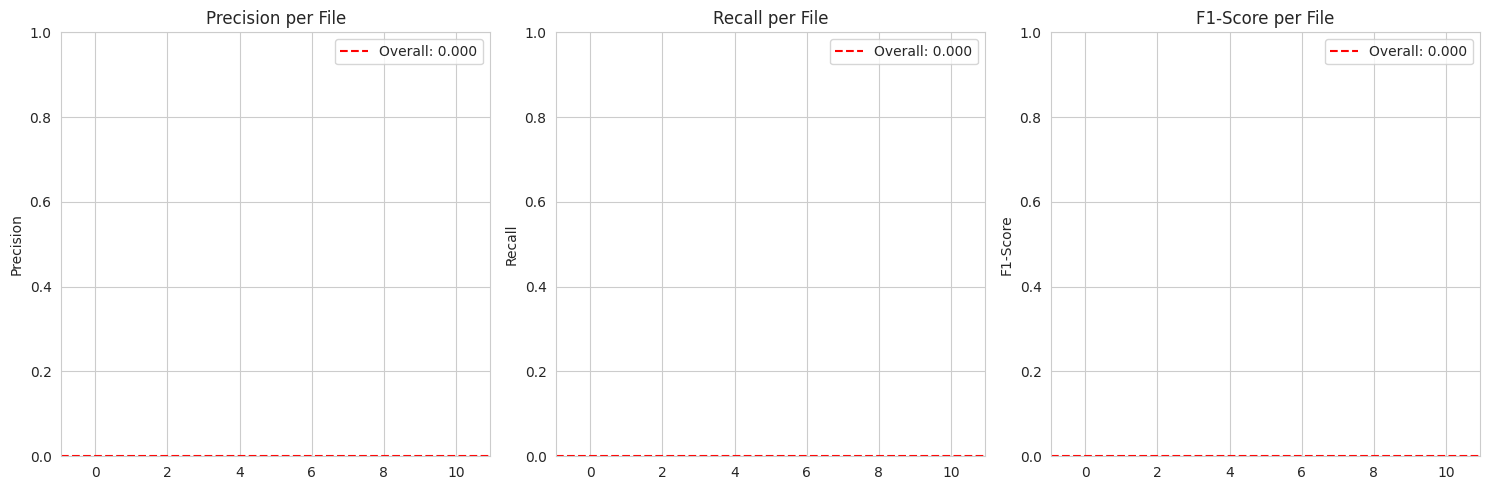

In [6]:
# Bar plot of metrics per file
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(range(len(results_df)), results_df['Precision'], color='steelblue')
axes[0].set_title('Precision per File')
axes[0].set_ylabel('Precision')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=overall_precision, color='r', linestyle='--', label=f'Overall: {overall_precision:.3f}')
axes[0].legend()

axes[1].bar(range(len(results_df)), results_df['Recall'], color='green')
axes[1].set_title('Recall per File')
axes[1].set_ylabel('Recall')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=overall_recall, color='r', linestyle='--', label=f'Overall: {overall_recall:.3f}')
axes[1].legend()

axes[2].bar(range(len(results_df)), results_df['F1'], color='orange')
axes[2].set_title('F1-Score per File')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim([0, 1])
axes[2].axhline(y=overall_f1, color='r', linestyle='--', label=f'Overall: {overall_f1:.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

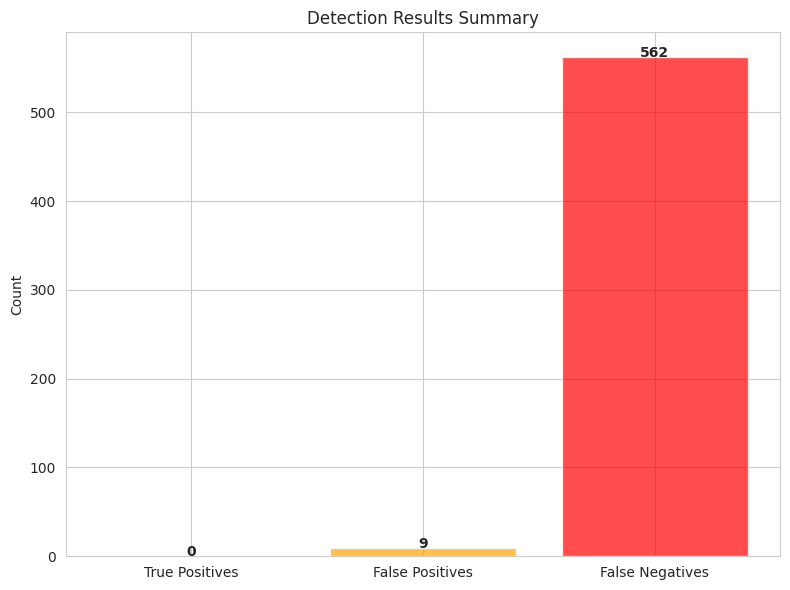

In [7]:
# Confusion matrix style visualization
fig, ax = plt.subplots(figsize=(8, 6))

categories = ['True Positives', 'False Positives', 'False Negatives']
values = [total_tp, total_fp, total_fn]
colors = ['green', 'orange', 'red']

ax.bar(categories, values, color=colors, alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Detection Results Summary')

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Save Results

In [8]:
# Save detailed results
results_df.to_csv('evaluation_results.csv', index=False)
print("Saved detailed results to 'evaluation_results.csv'")

# Save summary
summary = {
    'Total_TP': total_tp,
    'Total_FP': total_fp,
    'Total_FN': total_fn,
    'Overall_Precision': overall_precision,
    'Overall_Recall': overall_recall,
    'Overall_F1': overall_f1
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('evaluation_summary.csv', index=False)
print("Saved summary to 'evaluation_summary.csv'")

Saved detailed results to 'evaluation_results.csv'
Saved summary to 'evaluation_summary.csv'
